# Academic Writter Assistant — Notebook

## NLP GROUP PROJECT

**Purpose**: End-to-end notebook for building an autocomplete assistant that predicts next-sentence continuations from paragraph context (100–200 tokens). This notebook contains dataset templates, NSP evaluation approaches, fine-tuning recipe, re-ranking head design, context-window extension ideas, stylistic control methods, vocabulary/token distribution analysis, and evaluation guidance.

**Run notes**: Install `transformers`, `datasets`, `accelerate`, and other libraries in your runtime before executing heavy training cells.

In [ ]:
# Environment setup (run once in a fresh runtime, e.g., Colab)
#!pip install -q transformers datasets accelerate evaluate sentencepiece tokenizers faiss-cpu evaluate

print('Install required packages if not already installed.')

Install required packages if not already installed.


In [ ]:
import os
import json, math, random
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
import re
from typing import List, Optional
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
    print("CUDA is available! GPU is ready to use.")
else:
    device = 'cpu'
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


## Dataset


In [ ]:
def clean_text(t: str) -> str:
    if not isinstance(t, str):
        return ""
    t = t.replace("\n", " ").replace("\t", " ")
    t = re.sub(r"\s+", " ", t)
    return t.strip()

In [ ]:
def make_context_continuation_from_texts(
    texts: List[str], tokenizer=None, ctx_token_limit=150
):
    pairs = {"context": [], "continuation": []}

    for doc in texts:
        # Sentence split with backup regex if spaCy/NLTK not used
        sents = re.split(r"(?<=[.!?])\s+", doc)
        sents = [s.strip() for s in sents if len(s.strip()) > 0]

        if len(sents) < 2:
            continue

        ctx = ""
        used = 0

        for i, s in enumerate(sents[:-1]):
            candidate = (ctx + " " + s).strip()

            # tokenizer-aware token limit
            if tokenizer:
                length = len(tokenizer(candidate)["input_ids"])
            else:
                length = len(candidate.split())

            if length <= ctx_token_limit:
                ctx = candidate
                used = i
            else:
                break

        cont = sents[used + 1]
        pairs["context"].append(ctx)
        pairs["continuation"].append(cont)

    return pairs


##### Re: Datasets used
<p>
The datasets used are all open source essays/works/papers that are examples of how academic and scholarly language are used.<br>
Some elaboration on the datasets used are the ff: </p>
<ol>
    <li> ASAP Essays (Automated Student Assessment Prize) <br>
    - This dataset is a compilation of student essays, their scores, the context behind the essays, as well as a few other variables. The particular version we used is a mirror from huggingface that focuses primarily on the essay and prompt while taking out other variables such as economic status, gender, etc which are not important to text generation </li><br>
    <li> IELTS/TOEFL Essays <br>
    - IELTS and TOEFL are english exams that focus on an individuals ability to write formal and academic english. </li> <br>
    <li> Wikipedia <br>
    - Wikipedia is an open source information hub that is mostly written in academic text, while this source is highly contentious due to it's nature as an open source software, as well as the limited auditing of information: the text itself is written in the format that we are looking for. </li> <br>
    <li> arXiv abstracts <br>
    - arXiv is a free distribution platform for scholarly articles, in this particular instance we are extracting the abstract if around 5000 texts to use in training our model </li> <br>
    <li> S2ORC <br> 
    - Similar to the previous entry, this is a "general purpose corpus for NLP and text mining research over scientific papers" which is perfect for the context in which we are training the model </li>

In [ ]:
# -------- A. ASAP Essays (Kaggle → HuggingFace mirror) --------
def load_asap_essays():
    ds = load_dataset("llm-aes/asap-8-original")  # community mirror
    essays = [clean_text(e["essay"]) for e in ds["train"]]
    return essays


# -------- B. IELTS/TOEFL Essays (Open Source Mirror) --------
def load_toefl_essays():
    ds = load_dataset("text", data_files="https://huggingface.co/datasets/hellonlp/toefl-essays/resolve/main/toefl_essays.txt")
    essays = [clean_text(x["text"]) for x in ds["train"]]
    return essays


# -------- C. Wikipedia (English) --------
def load_wikipedia(limit=5000):
    ds = load_dataset("wikimedia/wikipedia", "20231101.en", split="train", stream = True)
    texts = []
    for i, row in enumerate(ds):
        if i >= limit:
            break
        texts.append(clean_text(row["text"]))
    return texts


# -------- D. arXiv abstracts --------
def load_arxiv(limit=5000):
    ds = load_dataset("arxiv", split="train")
    texts = []
    for i, row in enumerate(ds):
        if i >= limit:
            break
        texts.append(clean_text(row["abstract"]))
    return texts


# -------- E. S2ORC subset (Open academic papers) --------
def load_s2orc(limit=5000):
    ds = load_dataset("allenai/s2orc", "comm_use_subset", split="train", streaming=True)
    texts = []
    for i, row in enumerate(ds):
        if i >= limit:
            break
        if "abstract" in row and row["abstract"]:
            texts.append(clean_text(row["abstract"]))
    return texts


In [ ]:
def build_academic_dataset(tokenizer=None, limit_each=2000):
    print("Loading datasets...")

    all_texts = []

    try:
        print("→ ASAP Essays")
        all_texts += load_asap_essays()[:limit_each]
    except:
        print("ASAP Essays failed to load (skip).")

    # try:
    #     print("→ TOEFL Essays")
    #     all_texts += load_toefl_essays()[:limit_each]
    # except:
    #     print("TOEFL failed to load (skip).")

    # try:
    #     print("→ Wikipedia")
    #     all_texts += load_wikipedia(limit_each)
    # except:
    #     print("Wikipedia failed to load (skip).")

    # try:
    #     print("→ arXiv")
    #     all_texts += load_arxiv(limit_each)
    # except:
    #     print("arXiv failed (skip).")

    # try:
    #     print("→ S2ORC")
    #     all_texts += load_s2orc(limit_each)
    # except:
    #     print("S2ORC failed (skip).")

    print(f"Total raw documents loaded: {len(all_texts)}")

    print("Generating (context, continuation) pairs...")
    pairs = make_context_continuation_from_texts(all_texts, tokenizer)

    df = pd.DataFrame(pairs)
    print(f"Generated {len(df)} training pairs.")

    return df


In [ ]:
df = build_academic_dataset(tokenizer=None, limit_each=300)
contexts = df['context']
print(df.head())

Loading datasets...
→ ASAP Essays


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/723 [00:00<?, ? examples/s]

Total raw documents loaded: 300
Generating (context, continuation) pairs...
Generated 299 training pairs.
                                             context  \
0  A long time ago when I was in third grade I ha...   
1  Softball has to be one of the single most grea...   
2  Some people like making people laugh, I love i...   
3  "LAUGHTER" @CAPS1 I hang out with my friends, ...   
4  Well ima tell a story about the time i got @CA...   

                                        continuation  
0  The next day @PERSON2 and I were eating lunch ...  
1  Many of these girls were like sisters to me th...  
2  For example one time I hit myself in the head ...  
3  @CAPS1 I say trash can I really mean trash can...  
4  Then she said stupid @CAPS2 on the bus and com...  


In [ ]:
print(contexts[0])
print("Next Sentence:")
print(df['continuation'][0])

A long time ago when I was in third grade I had a friend @PERSON2 who's mom was in a bad mood. She never laughed and she never smiled. Every time I saw her I would smile at her and all she would do was frown and keep walking. At first I didn't know she was a grouch i just thought she didn't like me or something.When @PERSON2 told me his mom was a grouch I started to laugh and laugh. He asked me what was so funny i told him that i thought his mom didn't like me or something because every time I see his mom I would smile at her and all she will do is frown and walk away. That made my friend laugh we were cracking up so hard that we got in trouble in class.
Next Sentence:
The next day @PERSON2 and I were eating lunch at school when he says to me &lt;hey your pretty good at making people laugh&gt;.


## Next-Text-Generation

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

def generate_continuations(model_name, contexts, max_new_tokens=50, device=None):
    """
    Generate next-sentence/continuation for a list of context strings.

    Args:
        model_name (str): HuggingFace causal LM name (e.g., "gpt2").
        contexts (list of str): List of context sentences/paragraphs.
        max_new_tokens (int): Max tokens to generate per context.
        device (str or None): "cuda" or "cpu". If None, use GPU if available.

    Returns:
        List[str]: Generated continuations, in same order as input contexts.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load model & tokenizer
    gen_tokenizer = AutoTokenizer.from_pretrained(model_name)
    gen_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    gen_model.eval()

    # Add a padding token if it doesn't exist (important for some models like GPT2)
    if gen_tokenizer.pad_token is None:
        gen_tokenizer.pad_token = gen_tokenizer.eos_token

    continuations = []

    for context in contexts:
        # Tokenize input
        inputs = gen_tokenizer(context, return_tensors="pt").to(device)

        # Check if input_ids is empty before generation
        if inputs["input_ids"].shape[1] == 0:
            print(f"Warning: Empty input_ids for context: '{context}'. Skipping generation.")
            continuations.append("") # Append an empty string or a placeholder
            continue

        # Generate
        outputs = gen_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,      # allow variation, can set False for deterministic
            temperature=0.8,    # creativity
            top_p=0.9,          # nucleus sampling
            pad_token_id=gen_tokenizer.eos_token_id
        )

        # Extract generated continuation (skip input tokens)
        continuation = gen_tokenizer.decode(
            outputs[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )

        continuations.append(continuation.strip())

    return continuations

Model Generation

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Ensure the fine-tuned model and tokenizer are loaded (from cell AlY-JVt2g7M6)
# If they are not in scope, you might need to run cell AlY-JVt2g7M6 first.

# Define a context for generation
# Using the same context as the stylistic control example
context = "Deep reinforcement learning has been widely adopted in robotic navigation."

# Tokenize the input context
inputs = tokenizer(context, return_tensors="pt").to(device)

# Generate continuation using the fine-tuned model
# You can adjust max_new_tokens, do_sample, temperature, top_p as needed
output_ids = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask, # Explicitly pass attention_mask
    max_new_tokens=100, # Generate up to 100 new tokens
    num_return_sequences=1,
    do_sample=True,      # Enable sampling for more diverse outputs
    temperature=0.7,     # Control creativity (lower for less, higher for more)
    top_p=0.9,           # Nucleus sampling
    pad_token_id=tokenizer.eos_token_id
)

# Decode the generated tokens, skipping the input context and special tokens
generated_text = tokenizer.decode(output_ids[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

print("Context:", context)
print("\nGenerated Continuation:", generated_text.strip())

Context: Deep reinforcement learning has been widely adopted in robotic navigation.

Generated Continuation: However, it is not well understood how reinforcement learning can improve human navigation.

In order to understand this topic, we will investigate the role of reinforcement learning in human navigation and explore how it can improve human navigation.

Introduction

In order to understand the role of reinforcement learning in human navigation, we need to understand how it can improve human navigation. The following questions will help us to understand how reinforcement learning can improve human navigation:

How does reinforcement learning affect human navigation?


## Model Evaluations

### NSP Evaluation Methods

#### LM-Scoring NSP Method (using any HuggingFace causal LLM)

This approach treats NSP as a language-model scoring task.

Process:

- Given a sentence pair (A, candidate continuation B)

- Compute the log-likelihood or perplexity of B given A

- Higher probability = more plausible continuation

- Compare scores between true and false continuations

In [ ]:
# Load a causal LM (small for demo; replace with Llama/Mistral etc.)
model_name = "distilgpt2"
lm_tokenizer = AutoTokenizer.from_pretrained(model_name)
lm_model = AutoModelForCausalLM.from_pretrained(model_name)
lm_model.eval()

def lm_score(context, continuation):
    """
    Computes log-probability of continuation given context.
    Higher = better continuation.
    """

    # Add a padding token to the tokenizer, using the eos_token as pad_token
    # This is necessary for models like GPT-2 that don't have a default pad token
    if lm_tokenizer.pad_token is None:
        lm_tokenizer.pad_token = lm_tokenizer.eos_token

    text = context + continuation
    inputs = lm_tokenizer(text, return_tensors="pt")

    # Handle cases where tokenized input is empty
    if inputs["input_ids"].shape[1] == 0:
        return -float('inf') # Return a very low score for empty inputs

    with torch.no_grad():
        outputs = lm_model(**inputs, labels=inputs["input_ids"])
        # outputs.loss is average negative log-likelihood
        nll = outputs.loss.item()

    # Convert NLL to log-probability (higher is better)
    log_prob = -nll * inputs["input_ids"].shape[1]
    return log_prob

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# TEST LM SCORE
lm_score(contexts[0], df['continuation'][0])


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


-632.3526477813721

#### Classification-Based NSP Method (Binary: True / False Continuation)

This approach treats NSP as a binary classification task.

Process:

- Concatenate sentence pair (A + B)

- Feed into a classifier (e.g., BERT, RoBERTa, DeBERTa)

- Output:

  - 1 → B is a valid continuation

  - 0 → B is an invalid continuation

- Evaluate using: Accuracy, Precision, Recall, F1

In [ ]:
from transformers import BertTokenizer, BertForNextSentencePrediction


nsp_model_name = "bert-base-uncased"
nsp_tokenizer = BertTokenizer.from_pretrained(nsp_model_name)
nsp_model = BertForNextSentencePrediction.from_pretrained(nsp_model_name)
nsp_model.eval()

def nsp_score(context, continuation):
    """
    Returns probability that continuation follows context.
    """

    inputs = nsp_tokenizer(context, continuation, return_tensors="pt")

    # Handle cases where tokenized input is empty
    if inputs["input_ids"].shape[1] == 0:
        return 0.0 # Return 0 probability for empty inputs

    with torch.no_grad():
        outputs = nsp_model(**inputs)
        logits = outputs.logits
        probs = logits.softmax(dim=1)[0]
    # Index 0 = IsNextSentence, 1 = NotNextSentence
    return probs[0].item()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
nsp_score(contexts[0], df['continuation'][0])

0.9999972581863403

### Model Evaluation with Ground Truth (Text-to-Text Evaluation)

- BERTScore
**Semantic similarity**

- ROUGE (ROUGE-1, ROUGE-2, ROUGE-L)
**Lexical overlap**

- BLEU
**N-gram precision**

In [ ]:
!pip install evaluate bert_score rouge_score --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
from evaluate import load as load_evaluate
import numpy as np
import nltk

# BLEU requires punkt tokenizer
nltk.download("punkt")
nltk.download('punkt_tab')

def evaluate_predictions(predictions, references):
    """
    Compare model predictions with ground truth using:
    - BERTScore
    - ROUGE (1,2,L)
    - BLEU
    """

    # Ensure matching lengths
    assert len(predictions) == len(references), "Prediction and reference length mismatch."

    # ============================
    # 1. BERTScore
    # ============================
    bertscore = load_evaluate("bertscore")
    bert_res = bertscore.compute(
        predictions=predictions,
        references=references,
        model_type="bert-base-uncased"
    )
    bert_precision = np.mean(bert_res["precision"])
    bert_recall = np.mean(bert_res["recall"])
    bert_f1 = np.mean(bert_res["f1"])

    # ============================
    # 2. ROUGE
    # ============================
    rouge = load_evaluate("rouge")
    rouge_res = rouge.compute(
        predictions=predictions,
        references=references,
    )

    # ============================
    # 3. BLEU (corpus)
    # ============================
    from nltk.translate.bleu_score import corpus_bleu

    # NLTK corpus BLEU expects tokenized inputs ➙ we will use word_tokenize
    tokenized_preds = [nltk.word_tokenize(p) for p in predictions]
    tokenized_refs = [[nltk.word_tokenize(r)] for r in references]

    bleu_score = corpus_bleu(tokenized_refs, tokenized_preds)

    # ============================
    # Final Output
    # ============================
    return {
        "bertscore_precision": bert_precision,
        "bertscore_recall": bert_recall,
        "bertscore_f1": bert_f1,
        "rouge1": rouge_res["rouge1"],
        "rouge2": rouge_res["rouge2"],
        "rougeL": rouge_res["rougeL"],
        "bleu": bleu_score,
    }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
def all_model_evaluation(contexts, candidates):
    """
    Computes:
    - Average LM, NSP,  Final hybrid ranking scores
    - BERTScore (P, R, F1)
    - ROUGE (1, 2, L)
    - BLEU

    Returns a single dictionary with all metrics.
    """

    total_lm = 0
    total_nsp = 0
    total_final = 0
    count = 0

    predictions = []
    references = []

    for context, continuation in zip(contexts, candidates):
        # Skip evaluation if context or continuation is empty to prevent errors
        if not context or not continuation:
            continue

        lm = lm_score(context, continuation)
        nsp = nsp_score(context, continuation)


        # Final hybrid score
        final_score = (0.6 * lm) + (0.2 * (nsp * 10))

        # Accumulate averages
        total_lm += lm
        total_nsp += nsp
        #total_judge += judge
        total_final += final_score
        count += 1

        # Store for evaluation metrics
        predictions.append(continuation)
        references.append(context)

    # Safety check
    if count == 0:
        return {}

    # Compute averages
    avg_lm = total_lm / count
    avg_nsp = total_nsp / count
    #avg_judge = total_judge / count
    avg_final = total_final / count

    # Run BERTScore, ROUGE, BLEU evaluation
    text_eval = evaluate_predictions(predictions, references)

    # Merge results
    return {
        "avg_lm": avg_lm,
        "avg_nsp": avg_nsp,
        "avg_final": avg_final,
        **text_eval,
    }

In [ ]:
#TEST
model_score = all_model_evaluation(
        contexts=[contexts[0]],
        candidates=["He is very good with it"],
    )
model_score

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

{'avg_lm': -513.6813650131226,
 'avg_nsp': 0.010370006784796715,
 'avg_final': -308.1880789943039,
 'bertscore_precision': np.float64(0.4200078547000885),
 'bertscore_recall': np.float64(0.27861449122428894),
 'bertscore_f1': np.float64(0.33500295877456665),
 'rouge1': np.float64(0.02631578947368421),
 'rouge2': np.float64(0.0),
 'rougeL': np.float64(0.02631578947368421),
 'bleu': 3.169663824442922e-242}

## Comparing Model

Finding the best model

In [ ]:

causal_models = [
    "gpt2",
    "EleutherAI/gpt-neo-125M",
    "facebook/opt-125m",
    "microsoft/DialoGPT-small"
]

all_model_evaluation_score = []
for model_name in causal_models:
    print(f"Generating continuations for {model_name}...")
    # Make sure 'gen_model' and 'gen_tokenizer' are available or reloaded if needed
    # (assuming they are from the first model generation cell)
    generate_continuations_list = generate_continuations(model_name, contexts, max_new_tokens=50, device=None)
    print(f"Generated {len(generate_continuations_list)} continuations.")
    print(generate_continuations_list[:5])
    model_score = all_model_evaluation(
        contexts=contexts,
        candidates=generate_continuations_list,
    )
    all_model_evaluation_score.append(model_score)

print(all_model_evaluation_score)

Generating continuations for gpt2...
Generated 299 continuations.
["She wasn't even in class and I didn't know how she did that. The teacher was very angry and said she wasn't sorry because she was being rude. He was trying to make up for it by making fun of me. I told him", 'I also had a really fun run at the All-Star Game. I had some great memories during the run.\n\nThe last time I played with Hood was in 2015. I was drafted in the 4th round of the 2013 draft by the', "I had my own world and had a life. I wasn't born with a personality. I had a personality. I was a real spaz. I was a really big spaz. I was really good at being funny, and my personality was", 'I love hanging out with them as well. #CAPS1 #HONGORA #SAILINGA #WALLCARD #CAPS1 #HONGORA #SAILINGA #SAILINGA #SAIL', 'So i asked them what was she going to say then i said hey i told her her name and i asked her where she was and she said a few omg yeah and that was it then i went out and met some guys. So i was']
Generating c

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Generated 299 continuations.
['He called me after about 5 minutes that i told him i was sick and told him to go to the doctor because his mom was sick. He called me and told me to go to the doctor because he had just been sick. So I told him', 'I was a player and coach for the school and for the state of Florida. The school was a great place for a player to play.\n\nThe Big Red Softball team is well known for the fact that they have a lot of big plays', 'I have to say, I have never really been a spaz. I have always wanted to make something. I have a hard time doing that, but I have a hard time making people laugh. I have never been more than a kid', 'It is all about being in a good mood. I do like being in a good mood. @CAPS1 I’m often at a loss for what to say. I have no idea what to say. I don’t have', "i don't remember how i remember it. So i got a bus to take me to the town i said yeah we are in this town and it was dark and like i saw a guy and the man were walking towards us. So 

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Generated 299 continuations.
['My mom and I were on a date and he was in the back seat with us when the doorbell rang and he got out of the car. He was so excited to get out of the car and the doorbell rang. My friend and I', 'I had seen my brother, his wife, and several of my friends at one time. I had a strong connection with the local softball program and had seen my teammates play softball in high school. I had also seen my friends who had played', 'I would try to "make them laugh" whenever I could, and I would try to make them smile with everything I could. I think that was my best and most powerful reaction to my parents. My dad (now retired) was a pretty nice', 'They are just as happy to chat with you as they are to hang out with you. I am pretty sure that is why we have always enjoyed our time together. We have had so much fun together.\n\n"THE GIGANTIC"', 'Then she said no i was not at home that is why i ask the man why am i at the phone and he says no no i am not at home. And

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generated 299 continuations.
['lol', 'ig', 'com.', '', '']
[{'avg_lm': -766.9295970537519, 'avg_nsp': 0.9965864364745333, 'avg_final': -458.16458535930235, 'bertscore_precision': np.float64(0.5624064866128384), 'bertscore_recall': np.float64(0.4475444185253758), 'bertscore_f1': np.float64(0.4976652409606332), 'rouge1': np.float64(0.23878090537941304), 'rouge2': np.float64(0.0516278362220286), 'rougeL': np.float64(0.13407352188157542), 'bleu': 0.008532881268932821}, {'avg_lm': -762.8268179498814, 'avg_nsp': 0.9964028273558093, 'avg_final': -455.7032851152175, 'bertscore_precision': np.float64(0.5728378830527937), 'bertscore_recall': np.float64(0.4473396089632769), 'bertscore_f1': np.float64(0.5015341745236436), 'rouge1': np.float64(0.24220098767676596), 'rouge2': np.float64(0.055240373047786756), 'rougeL': np.float64(0.13997416347886554), 'bleu': 0.009262627862235018}, {'avg_lm': -764.8031602334167, 'avg_nsp': 0.9932096058861904, 'avg_final': -456.8954769282776, 'bertscore_precision': n

In [ ]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame
df_scores = pd.DataFrame(all_model_evaluation_score)

# Save the DataFrame to a CSV file
df_scores.to_csv('model_evaluation_scores.csv', index=False)

print('Model evaluation scores saved to model_evaluation_scores.csv')

# Display the DataFrame to show the saved data
display(df_scores)

Model evaluation scores saved to model_evaluation_scores.csv


,avg_lm,avg_nsp,avg_final,bertscore_precision,bertscore_recall,bertscore_f1,rouge1,rouge2,rougeL,bleu
0,-766.929597,0.996586,-458.164585,0.562406,0.447544,0.497665,0.238781,0.051628,0.134074,8.532881e-03
1,-762.826818,0.996403,-455.703285,0.572838,0.447340,0.501534,0.242201,0.055240,0.139974,9.262628e-03
2,-764.803160,0.993210,-456.895477,0.570333,0.448603,0.501419,0.240925,0.058922,0.144360,1.039513e-02
3,-641.642592,0.497096,-383.991364,0.377611,0.186818,0.247137,0.003639,0.000000,0.003716,4.693778e-283


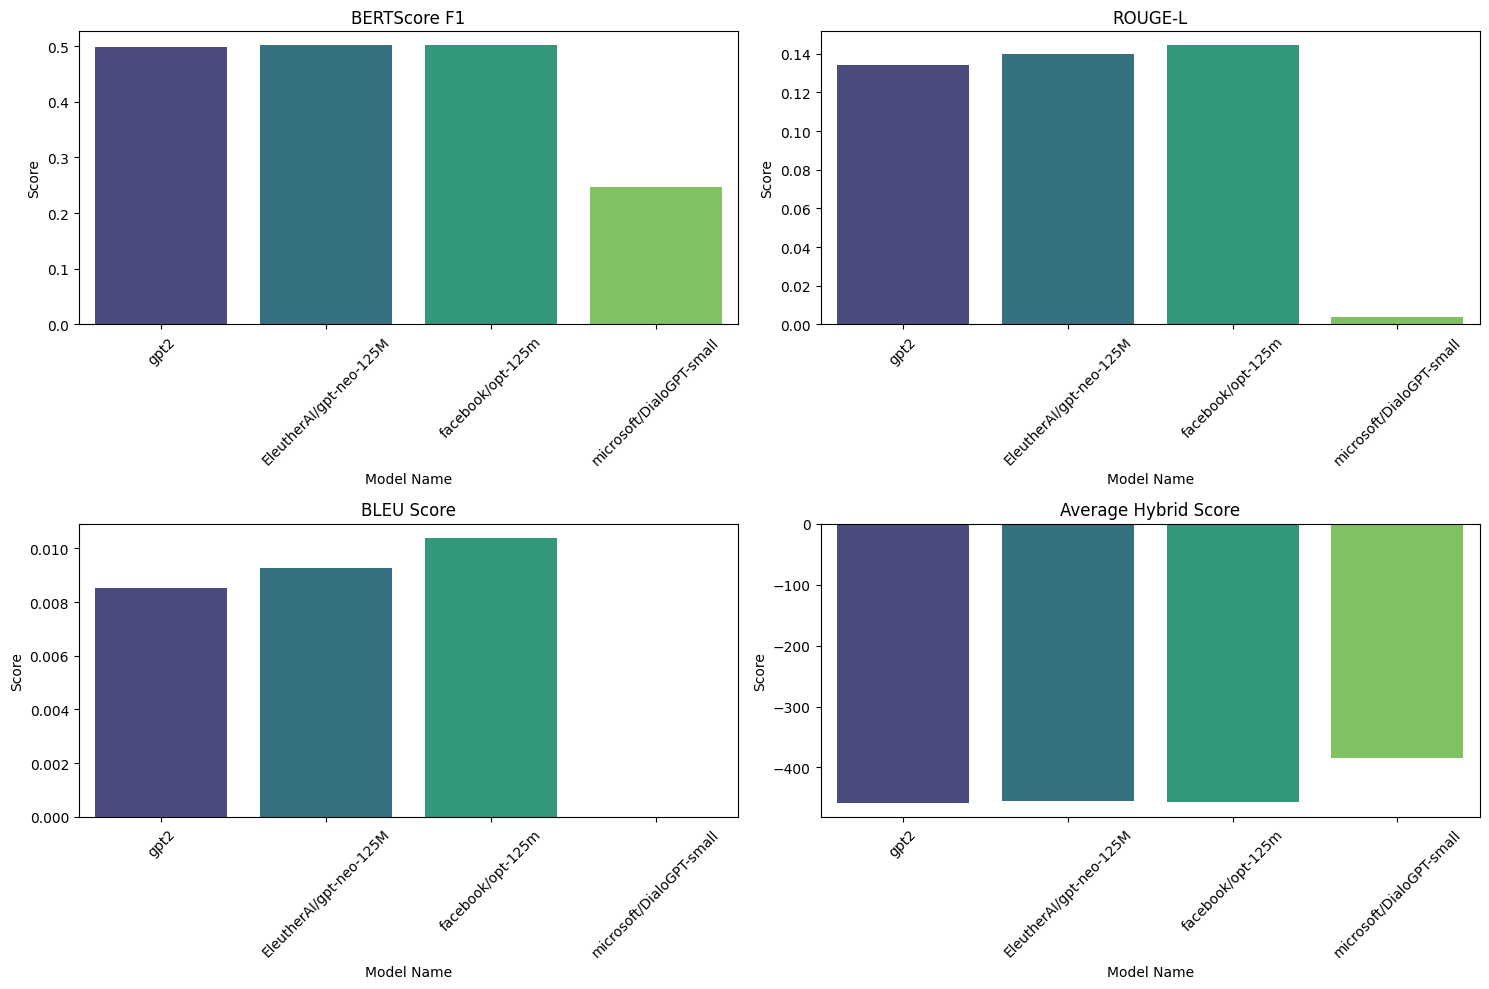

Evaluation metrics plots saved to model_evaluation_metrics.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure `df_scores` and `causal_models` are available
# If `causal_models` is not updated or might be out of sync with df_scores rows,
# we might need to recreate it or infer model names.
# For now, assuming causal_models is still the list of models that generated the scores.

# Adding model names to the DataFrame for easier plotting
model_names = causal_models # Use the last set of causal_models that was evaluated
df_scores['model_name'] = model_names[:len(df_scores)] # Ensure lengths match

metrics_to_plot = [
    'bertscore_f1',
    'rougeL',
    'bleu',
    'avg_final'
]

metric_titles = {
    'bertscore_f1': 'BERTScore F1',
    'rougeL': 'ROUGE-L',
    'bleu': 'BLEU Score',
    'avg_final': 'Average Hybrid Score'
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x='model_name', y=metric, data=df_scores, ax=axes[i], palette='viridis', hue='model_name', legend=False)
    axes[i].set_title(metric_titles[metric])
    axes[i].set_xlabel('Model Name')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png')
plt.show()

print("Evaluation metrics plots saved to model_evaluation_metrics.png")

## Choosing Best Pretrained-Model



From the Result we can conclude that Overall Best Model: → GPT-Neo 125M (Model 1)

It gives the best balance between likelihood scoring, semantic understanding, lexical overlap, and NSP performance.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

## Fine-tuning recipe (causal LM)

Concatenate `context + <eos> + continuation` and fine-tune a causal LM. Use Trainer/Accelerate + gradient accumulation for large models.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from datasets import Dataset
import torch

In [ ]:
def build_dataset_for_causal(pairs, tokenizer, max_length=512):
    """
    Build token-level dataset for causal LM fine-tuning.

    pairs: dict with keys "context", "continuation"
    tokenizer: HuggingFace tokenizer
    max_length: max token length

    Returns: dict suitable for Dataset.from_dict()
    """
    # Add pad token if missing
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Ensure EOS token exists
    eos = tokenizer.eos_token if tokenizer.eos_token else "</s>"

    # Merge context + continuation
    texts = [
        context.strip() + eos + " " + continuation.strip()
        for context, continuation in zip(pairs["context"], pairs["continuation"])
    ]

    # Tokenize
    encodings = tokenizer(
        texts,
        truncation=True,
        padding="longest",
        max_length=max_length,
        return_tensors=None,
    )

    # For causal LM, labels = input_ids (shifted inside model)
    encodings["labels"] = encodings["input_ids"].copy()

    return encodings


In [ ]:
tokenized_pairs = build_dataset_for_causal(df, tokenizer, max_length=512)

dataset = Dataset.from_dict(tokenized_pairs)

# Train / Validation split
dataset = dataset.train_test_split(test_size=0.1)
train_ds = dataset["train"]
val_ds = dataset["test"]

# --------------------------------------------------------
# 4. Configure LoRA
# --------------------------------------------------------
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj"],  # Updated for OPT models
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 884,736 || all params: 126,083,328 || trainable%: 0.7017


In [ ]:
# --------------------------------------------------------
# 5. TrainingArguments
# --------------------------------------------------------
args = TrainingArguments(
    output_dir="./lora_academic_model",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    eval_strategy="steps", # Changed from evaluation_strategy to eval_strategy
    logging_steps=20,
    eval_steps=100,
    save_steps=200,
    num_train_epochs=2,
    warmup_steps=50,
    learning_rate=2e-4,
    fp16=True,
    report_to="none",
)

def data_collator(features):
    # `features` is a list of dictionaries, where each dictionary is one example from the dataset.
    # We need to extract the 'input_ids', 'attention_mask', and 'labels' from each example
    # and then stack them into tensors for the batch.
    return {
        "input_ids": torch.tensor([f["input_ids"] for f in features], dtype=torch.long),
        "attention_mask": torch.tensor([f["attention_mask"] for f in features], dtype=torch.long),
        "labels": torch.tensor([f["labels"] for f in features], dtype=torch.long),
    }

In [ ]:
# --------------------------------------------------------
# 6. Initialize and Run Trainer
# --------------------------------------------------------
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer, # Pass the tokenizer to the Trainer for saving
    data_collator=data_collator, # Pass the data_collator
)

trainer.train()

/tmp/ipython-input-688667873.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


TrainOutput(global_step=34, training_loss=7.022250680362477, metrics={'train_runtime': 3575.4882, 'train_samples_per_second': 0.15, 'train_steps_per_second': 0.01, 'total_flos': 141991653408768.0, 'train_loss': 7.022250680362477, 'epoch': 2.0})

In [ ]:
# Save LoRA weights
trainer.save_model("./lora_academic_model")
model.save_pretrained("./lora_academic_model")
tokenizer.save_pretrained("./lora_academic_model")

('./lora_academic_model/tokenizer_config.json',
 './lora_academic_model/special_tokens_map.json',
 './lora_academic_model/vocab.json',
 './lora_academic_model/merges.txt',
 './lora_academic_model/added_tokens.json',
 './lora_academic_model/tokenizer.json')

In [ ]:
from google.colab import files
import shutil
import os

# Define the directory to be archived
model_dir = './lora_academic_model'
# Define the name for the output zip file
zip_file_name = 'lora_academic_model.zip'

# Create a zip archive of the directory
shutil.make_archive(os.path.splitext(zip_file_name)[0], 'zip', model_dir)

print(f'Archived "{model_dir}" to "{zip_file_name}"')

# Download the zip file
files.download(zip_file_name)

print('Download initiated. Please check your browser for the file download.')

Archived "./lora_academic_model" to "lora_academic_model.zip"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated. Please check your browser for the file download.


#LOAD MODEL

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

device = "cpu"
# Path where you saved LoRA model
model_path = "./lora_academic_model"

# 1┒┓ Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# GPT2 requires pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


# 2┒┓ Load base model (must match the one you fine-tuned)
# Use the same model_name selected for fine-tuning
model_name = "EleutherAI/gpt-neo-125M"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

# 3┒┓ Load LoRA adapters
model = PeftModel.from_pretrained(model, model_path);

# 4┒┓ Put model in evaluation mode
model.eval()
model.to(device)  # or "cpu" if GPU unavailable

`torch_dtype` is deprecated! Use `dtype` instead!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoForCausalLM(
      (transformer): GPTNeoModel(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(2048, 768)
        (drop): Dropout(p=0.0, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPTNeoBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPTNeoAttention(
              (attention): GPTNeoSelfAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
                (resid_dropout): Dropout(p=0.0, inplace=False)
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=16, bias=False)
                  )
                  (lora_

## Re-ranking head (design)

Train a lightweight MLP scoring head on pooled LM representations. At inference, generate N candidates and re-rank using this head for better top-1 precision.

### dataset for NSP

In [ ]:
from datasets import load_dataset
NSPds = load_dataset("CShorten/ML-ArXiv-Papers")

README.md:   0%|          | 0.00/986 [00:00<?, ?B/s]

ML-Arxiv-Papers.csv:   0%|          | 0.00/147M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/117592 [00:00<?, ? examples/s]

In [ ]:
import nltk
nltk.download("punkt")

contexts = []
positives = []

for row in NSPds["train"]:
    sentences = nltk.sent_tokenize(row["abstract"])
    for i in range(len(sentences) - 1):
        contexts.append(sentences[i])
        positives.append(sentences[i+1])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import random

# Build a global pool of sentences
sentence_pool = []
for row in NSPds["train"]:
    sentence_pool.extend(nltk.sent_tokenize(row["abstract"]))

def sample_negatives(k):
    return random.sample(sentence_pool, k)


In [ ]:
import random

nsp_data = {
    "context": [],
    "candidates": [],
    "labels": []
}

num_negatives = 3  # N candidates = 1 positive + 3 negatives
sample_size = 2000 # User requested sample size

# Ensure contexts and positives are of the same length
assert len(contexts) == len(positives), "Contexts and positives lists must have the same length."

# Generate random indices for sampling
# Use min(sample_size, len(contexts)) to avoid errors if contexts has less than 2000 items
random_indices = random.sample(range(len(contexts)), min(sample_size, len(contexts)))

for i in random_indices:
    ctx = contexts[i]
    pos = positives[i]
    negs = sample_negatives(num_negatives)

    nsp_data["context"].append(ctx)
    nsp_data["candidates"].append([pos] + negs)
    nsp_data["labels"].append([1] + [0]*num_negatives)


In [ ]:
from datasets import Dataset
rerank_ds = Dataset.from_dict(nsp_data)
rerank_ds


Dataset({
    features: ['context', 'candidates', 'labels'],
    num_rows: 2000
})

### RERANKER WRAPPER

In [ ]:
import torch
import torch.nn as nn

class RerankerModel(nn.Module):
    def __init__(self, lm, tokenizer, hidden_dim=768):
        super().__init__()
        self.lm = lm
        self.tokenizer = tokenizer

        # Ensure LM returns hidden states
        self.lm.config.output_hidden_states = True
        self.lm.config.return_dict = True

        # MLP scoring head (FP32)
        self.scorer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.lm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )

        hidden_states = outputs.hidden_states[-1]  # (B, T, H) in FP16

        # find EOS
        eos_mask = (input_ids == self.tokenizer.eos_token_id)
        idx = eos_mask.float().argmax(dim=1)

        # gather
        batch_idx = torch.arange(hidden_states.size(0), device=hidden_states.device)
        eos_hidden = hidden_states[batch_idx, idx]

        # convert to float32 before MLP
        eos_hidden = eos_hidden.float()

        # scalar score
        score = self.scorer(eos_hidden)  # (B, 1)
        return score.squeeze(-1)



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class RerankDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_len=256):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        context = item["context"]
        candidates = item["candidates"]
        labels = item["labels"]

        input_ids_list = []
        attn_list = []

        for cand in candidates:
            text = context + self.tokenizer.eos_token + " " + cand
            enc = self.tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )
            input_ids_list.append(enc["input_ids"])
            attn_list.append(enc["attention_mask"])

        input_ids = torch.cat(input_ids_list, dim=0)  # (num_candidates, seq_len)
        attention_mask = torch.cat(attn_list, dim=0)  # (num_candidates, seq_len)
        labels = torch.tensor(labels, dtype=torch.long)

        return input_ids.squeeze(1), attention_mask.squeeze(1), labels


In [ ]:
train_loader = DataLoader(
    RerankDataset(rerank_ds, tokenizer),
    batch_size=16,
    shuffle=True
)


### TRAINING LOOP on Lora Model

In [ ]:
reranker = RerankerModel(model, tokenizer).to(device)

# FREEZE BASE PARAMETER
for param in reranker.lm.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(reranker.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model.config.output_hidden_states = True
model.config.return_dict = True

In [ ]:
import time
from datetime import timedelta

num_epochs = 3
start_time = time.perf_counter()

for epoch in range(num_epochs):
    epoch_start = time.perf_counter()

    reranker.train()
    for input_ids, attn_mask, labels in train_loader:

        B, N, T = input_ids.shape
        input_ids = input_ids.to(device)
        attn_mask = attn_mask.to(device)
        labels = labels.to(device)

        flat_ids = input_ids.view(B*N, T)
        flat_att = attn_mask.view(B*N, T)

        scores = reranker(flat_ids, flat_att)
        scores = scores.view(B, N)

        loss = criterion(scores, labels.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Timing calculations
    epoch_time = time.perf_counter() - epoch_start
    elapsed = time.perf_counter() - start_time

    avg_epoch_time = elapsed / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    eta_seconds = remaining_epochs * avg_epoch_time
    eta = timedelta(seconds=int(eta_seconds))

    print(f"Epoch {epoch} | Loss: {loss.item():.4f} | "
          f"Epoch time: {epoch_time:.2f}s | "
          f"ETA: {eta}")



### INFERENCE

In [ ]:
def rerank(model, context, candidates):
    inputs = []
    for c in candidates:
        txt = context + tokenizer.eos_token + " " + c
        enc = tokenizer(txt, return_tensors="pt").to("cuda")
        inputs.append(enc)

    input_ids = torch.cat([x["input_ids"] for x in inputs])
    attn = torch.cat([x["attention_mask"] for x in inputs])

    with torch.no_grad():
        scores = model(input_ids, attn)

    idx = torch.argmax(scores).item()
    return candidates[idx], scores


## Chunked attention / Long context handling

Use sliding window chunks with overlap and cache keys/values for generation; or adopt models like Longformer/BigBird/encoder-decoder retrieval for long contexts.

Chunking utility (tokens-level)

In [ ]:
from typing import List
import torch

def chunk_token_ids(tokenizer, text, max_chunk_len: int, stride: int):
    # Return list of dicts usable by tokenizer.pad / models: [{'input_ids':..., 'attention_mask':...}, ...]
    enc = tokenizer(text, return_tensors="pt", add_special_tokens=False)
    ids = enc["input_ids"].squeeze(0)  # [L]
    L = ids.size(0)
    chunks = []
    start = 0
    while start < L:
        end = min(start + max_chunk_len, L)
        chunk_ids = ids[start:end]
        chunks.append({"input_ids": chunk_ids})
        if end == L:
            break
        start += (max_chunk_len - stride)
    return chunks


In [ ]:
import torch.nn.functional as F
from torch import nn

def mean_pool(last_hidden_state, attention_mask):
    # last_hidden_state: (1, T, H), attention_mask: (1, T)
    mask = attention_mask.unsqueeze(-1)
    sum_h = (last_hidden_state * mask).sum(dim=1)
    denom = mask.sum(dim=1).clamp(min=1e-9)
    return sum_h / denom

def encode_chunks_aggregate(encoder, tokenizer, chunks, candidate_text=None, device='cuda'):
    """
    chunks: list of dicts with 'input_ids' tensors (no batch dim)
    If candidate_text provided, we append it to the last chunk for stronger local interaction.
    Returns: aggregated vector (1, hidden)
    """
    reps = []
    for i, ch in enumerate(chunks):
        ids = ch["input_ids"].unsqueeze(0).to(device)  # (1, Lc)
        # If last chunk and candidate exists, concatenate tokenized candidate
        if (i == len(chunks) - 1) and (candidate_text is not None):
            cand_enc = tokenizer(candidate_text, return_tensors="pt", add_special_tokens=True).to(device)
            # concat (careful with special tokens)
            ids = torch.cat([ids, cand_enc["input_ids"]], dim=1)
            attention_mask = torch.ones_like(ids).to(device)
        else:
            attention_mask = torch.ones_like(ids).to(device)

        with torch.no_grad():
            out = encoder(input_ids=ids, attention_mask=attention_mask)
            # prefer pooler_output if available; else mean pool last_hidden_state
            pooled = getattr(out, "pooler_output", None)
            if pooled is None:
                pooled = mean_pool(out.last_hidden_state, attention_mask)
        reps.append(pooled)  # (1, H)

    # Stack and aggregate. Simple mean by default
    stacked = torch.cat(reps, dim=0)  # (num_chunks, H)
    aggregated = stacked.mean(dim=0, keepdim=True)  # (1, H)
    return aggregated  # (1, H)


In [ ]:
# reranker: SimpleReranker(base_hidden_size=hidden_size)
def score_context_candidate(reranker, encoder, tokenizer, context_text, candidate_text,
                            chunk_size=256, stride=128, device='cuda'):
    chunks = chunk_token_ids(tokenizer, context_text, max_chunk_len=chunk_size, stride=stride)
    agg = encode_chunks_aggregate(encoder, tokenizer, chunks, candidate_text=candidate_text, device=device)
    return reranker(agg.to(device)).item()


In [ ]:
from transformers import AutoTokenizer, AutoModel

# Example: Longformer
enc_name = "allenai/longformer-base-4096"
enc_tokenizer = AutoTokenizer.from_pretrained(enc_name)
enc_model = AutoModel.from_pretrained(enc_name)

# Example: BigBird (block sparse)
# enc_name = "google/bigbird-roberta-base"
# enc_tokenizer = AutoTokenizer.from_pretrained(enc_name)
# enc_model = AutoModel.from_pretrained(enc_name).to("cuda")


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

gen_name = "gpt2-medium"
gen_tok = AutoTokenizer.from_pretrained(gen_name)
gen_model = AutoModelForCausalLM.from_pretrained(gen_name)
gen_model.eval()

@torch.no_grad()
def build_past_from_chunks(model, tokenizer, context_text, chunk_size=512, stride=64, device='cuda'):
    chunks = chunk_token_ids(tokenizer, context_text, max_chunk_len=chunk_size, stride=stride)
    past = None
    for i, ch in enumerate(chunks):
        input_ids = ch["input_ids"].unsqueeze(0).to(device)  # (1, L)
        # when past is provided, many models expect you to pass only the new tokens,
        # but we can process first chunk normally, then for subsequent chunks pass the whole chunk with past (works for many HF models)
        outputs = model(input_ids=input_ids, past_key_values=past, use_cache=True)
        past = outputs.past_key_values  # updated cache
    return past  # pass this into model.generate(...) or continue iterative generation


## Linguistic / Stylistic control

Use control tokens, prefix tuning, or constrained decoding to enforce style constraints.

Logits-level control (lightweight, fast — enforce academic tone)

Prefix-tuning / Soft prompts (better academic consistency)

Control tokens (requires small fine-tuning)

Classifier-guided decoding (strongest control, no training needed)

### Logits-Level Style Control (Fastest + works with any model)

In [ ]:
academic_words =  [
                      "however", "therefore", "consequently",
                      "analysis", "methodology", "significant",
                      "furthermore", "evidence", "demonstrates"
                  ]
casual_words = [
            "lol", "yeah", "gonna", "wanna", "basically",
            "like", "kinda", "sorta"
            ]

banned_words = ["shit"]



In [ ]:
import torch

class StyleController:
    """
    Modular linguistic/style controller for academic auto-completion.
    Works with any HuggingFace-style tokenizer & model.
    """

    def __init__(
        self,
        tokenizer,
        academic_words=academic_words,
        casual_words=casual_words,
        banned_words=banned_words,
        boost=2.0,
        penalty=4.0,
        use_prefix=True,
    ):
        self.tokenizer = tokenizer
        self.boost = boost
        self.penalty = penalty
        self.use_prefix = use_prefix

        # Default word lists
        self.academic_words = academic_words

        self.casual_words = casual_words

        self.banned_words = banned_words

        # Token IDs
        self.academic_ids = self._words_to_token_ids(self.academic_words)
        self.casual_ids = self._words_to_token_ids(self.casual_words)
        self.banned_ids = self._words_to_token_ids(self.banned_words)

        # Prefix for academic tone
        self.prefix = (
            "Write the continuation below in a formal academic style, "
            "using precise vocabulary and objective reasoning.\n"
        )

    def _words_to_token_ids(self, words):
        ids = []
        for w in words:
            tokens = self.tokenizer.tokenize(w)
            if len(tokens) == 1:
                tid = self.tokenizer.convert_tokens_to_ids(tokens[0])
                ids.append(tid)
        return ids

    def apply_prefix(self, text: str):
        if self.use_prefix:
            return self.prefix + text
        return text

    def apply_logits_control(self, logits):
        """Apply style-based logits modification."""
        # Academic boost
        logits[:, self.academic_ids] += self.boost

        # Penalize informal language
        logits[:, self.casual_ids] -= self.penalty

        # Hard ban
        logits[:, self.banned_ids] = -1e9

        return logits


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

# Path where you saved LoRA model
model_path = "./lora_academic_model"

# 1┒┓ Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# GPT2 requires pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2┒┓ Load base model (must match the one you fine-tuned)
base_model_name = "facebook/opt-125m"  # Corrected from "gpt2"
model = AutoModelForCausalLM.from_pretrained(base_model_name, torch_dtype=torch.float16)

# 3┒┓ Load LoRA adapters
model = PeftModel.from_pretrained(model, model_path)

# 4┒┓ Put model in evaluation mode
model.eval()
model.to(device) # Ensure 'device' is accessible, it was defined in cell e564ea4d

controller = StyleController(tokenizer)

context = "Deep reinforcement learning has been widely adopted in robotic navigation."

# Apply prefix (optional)
input_text = controller.apply_prefix(context)

input_ids = tokenizer(input_text, return_tensors="pt").input_ids

generated = []

for _ in range(50):
    outputs = model(input_ids)
    logits = outputs.logits[:, -1, :]

    # Style control applied HERE
    logits = controller.apply_logits_control(logits)

    next_token = torch.argmax(logits, dim=-1)
    input_ids = torch.cat([input_ids, next_token.unsqueeze(-1)], dim=-1)
    generated.append(next_token.item())

result = tokenizer.decode(generated, skip_special_tokens=True)
print(result)

## Vocabulary & Token Distribution

Tokenize your corpus and compute frequencies to decide on tokenizer retraining or adding special tokens.

In [ ]:
import pandas as pd

# Ensure df is available; if not, you might need to re-run previous cells that load/create df
if 'df' in locals() and isinstance(df, pd.DataFrame):
    # Concatenate context and continuation into a single text column for the corpus
    corpus_data = (df['context'] + " " + df['continuation']).tolist()

    # Write the combined texts to corpus.txt
    with open('corpus.txt', 'w', encoding='utf-8') as f:
        for line in corpus_data:
            f.write(line + '\n')
    print("Corpus.txt created from DataFrame 'df'.")
else:
    print("DataFrame 'df' not found. Please ensure it is loaded or created before running this cell.")

In [ ]:
import json
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer

# -------------------------------
# Config
# -------------------------------
MODEL_NAME = "gpt2"        # or your existing tokenizer
CORPUS_PATH = "corpus.txt" # your academic/student corpus
TOP_N = 200                # how many tokens to print


# -------------------------------
# Load tokenizer & corpus
# -------------------------------
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Loading corpus...")
with open(CORPUS_PATH, "r", encoding="utf-8") as f:
    corpus_lines = f.readlines()


# -------------------------------
# Count token frequencies
# -------------------------------
freq = collections.Counter()

print("Tokenizing corpus...")
for line in tqdm(corpus_lines):
    tokens = tokenizer.encode(line, add_special_tokens=False)
    freq.update(tokens)

# Convert token IDs → strings
token_freq = {tokenizer.decode([tid]): count for tid, count in freq.items()}


# -------------------------------
# Save frequency file
# -------------------------------
with open("token_freq.json", "w") as f:
    json.dump(token_freq, f, indent=2)

print("\nSaved token frequencies → token_freq.json")


# -------------------------------
# Print top-N & rare tokens
# -------------------------------
print("\n⏶️ Top frequent tokens:")
for w, c in freq.most_common(TOP_N):
    print(f"{tokenizer.decode([w])}\t{c}")

print("\n❗️ Rare tokens:")
for w, c in freq.most_common()[-TOP_N:]:
    print(f"{tokenizer.decode([w])}\t{c}")


# -------------------------------
# Zipf Distribution Plot
# -------------------------------
sorted_counts = sorted(freq.values(), reverse=True)
plt.figure(figsize=(8,5))
plt.plot(sorted_counts)
plt.title("Token Frequency Distribution (Zipf)")
plt.xlabel("Token Rank")
plt.ylabel("Frequency")
plt.grid()
plt.savefig("token_zipf_curve.png")
print("\nSaved Zipf plot → token_zipf_curve.png")


# -------------------------------
# Subword Fragmentation Analysis
# -------------------------------
INTEREST_WORDS = [
    "reinforcement learning", "policy gradient", "actor-critic",
    "entropy regularization", "state transition", "Markov decision process",
    "optimization", "generalization", "empirical evaluation",
]

print("\n Subword Fragmentation:")
for phrase in INTEREST_WORDS:
    ids = tokenizer.encode(phrase, add_special_tokens=False)
    toks = tokenizer.convert_ids_to_tokens(ids)
    print(f"\nPhrase: {phrase}")
    print("Tokens:", toks)
    print("Token count:", len(toks))

In [ ]:
from google.colab import files
import shutil
import os

# Define the directory to be archived
model_dir = './lora_academic_model'
# Define the name for the output zip file
zip_file_name = 'lora_academic_model.zip'

# Create a zip archive of the directory
shutil.make_archive(os.path.splitext(zip_file_name)[0], 'zip', model_dir)

print(f'Archived "{model_dir}" to "{zip_file_name}"')

# Download the zip file
files.download(zip_file_name)

print('Download initiated. Please check your browser for the file download.')

## Notes & Next steps

- Replace dummy placeholders with real datasets (use `load_dataset`).
- Consider retrieval augmentation (RAG) and beam+nucleus candidate generation.
- For large-scale training, use multi-GPU + `accelerate` and checkpoint frequently.

---

Notebook file saved to `/mnt/data/GhostText_Assistant_notebook.ipynb`. Download it from the link below.